# Auto Encoder

オートエンコーダ。

入力したものをそのまま出力するようなニューラルネットワーク。  
**encoder**と**decoder**の2つの部分からなる。

- encoder：入力を低次元のベクトルに変換する
- decoder：encoderの出力を元の次元に戻す

低次元に圧縮したベクトルを潜在変数と呼ぶ。

<br>

ここではノーマルなオートエンコーダを実装する

活用例
- ノイズ削除
- 次元削減
- 異常検知

<br>

MNISTを使って、何ができるか試してみる

In [1]:
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from IPython.display import display
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
mnist = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

dataloader = DataLoader(mnist, batch_size=64, shuffle=True)

def write(model, n_images, dataloader, width=512):
    model.eval()
    with torch.no_grad():
        x, _ = next(iter(dataloader))
        x = x.view(x.size(0), -1)[:n_images].to(device)
        y = model(x)
    x = x.view(n_images, 1, 28, 28).cpu()
    y = y.view(n_images, 1, 28, 28).cpu()
    f = width // n_images
    x = transforms.Resize((f))(x)
    y = transforms.Resize((f))(y)
    grid = torchvision.utils.make_grid(torch.cat([x, y], dim=0), nrow=n_images)
    img = transforms.functional.to_pil_image(grid)
    display(img)

## モデル用意

`z_dim`: 潜在変数の次元数

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, z_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid(),
        )

    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z)
        return y

学習  
入力と出力の平均二乗誤差を損失とする

In [4]:
def train(model, n_epochs, dataloader, critetion, optimizer):
    model.train()
    for epoch in range(n_epochs):
        for x, _ in dataloader:
            optimizer.zero_grad()
            x = x.view(x.size(0), -1).to(device)
            y = model(x)
            loss = critetion(y, x)
            loss.backward()
            optimizer.step()
        print(f'{epoch+1:>3}epoch, loss:{loss.item()}')

In [5]:
z_dim = 10

In [6]:
ae = AutoEncoder(z_dim).to(device)

n_epochs = 5
critetion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=1e-3)

train(ae, n_epochs, dataloader, critetion, optimizer)

  1epoch, loss:0.022334514185786247
  2epoch, loss:0.01988178864121437
  3epoch, loss:0.02096368744969368
  4epoch, loss:0.01717730239033699
  5epoch, loss:0.02025085687637329


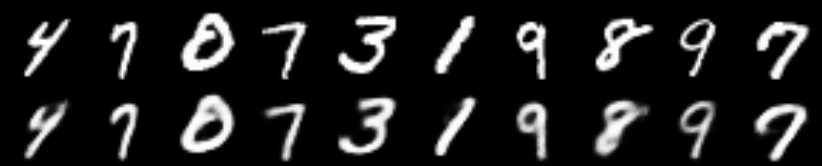

In [7]:
write(ae, 10, dataloader, width=800)

上が入力、下が出力。

### ノイズ削除

一度低次元に圧縮することで情報量が減るため、ノイズ削除に使える。  
上の例にもある通り、下の方がぼやけているのが分かる。

潜在変数の次元数を減らすと、もっとぼやける

  1epoch, loss:0.04975297302007675
  2epoch, loss:0.04854307323694229
  3epoch, loss:0.03570597618818283
  4epoch, loss:0.042685747146606445
  5epoch, loss:0.04220639914274216


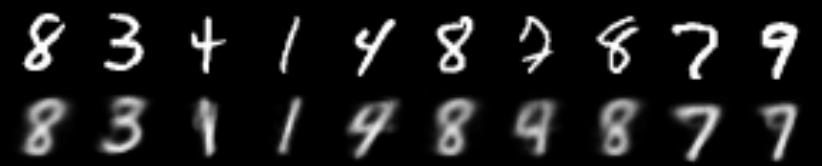

In [8]:
# 2に減らす
z_dim = 2

ae = AutoEncoder(z_dim).to(device)
n_epochs = 5
critetion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=1e-3)
train(ae, n_epochs, dataloader, critetion, optimizer)
write(ae, 10, dataloader, width=800)

### 次元削減

encoderは入力を低次元に圧縮しているので、そこだけ使えば次元削減ができる。

↑で学習したencoderを使って、二次元の潜在変数をプロットする。

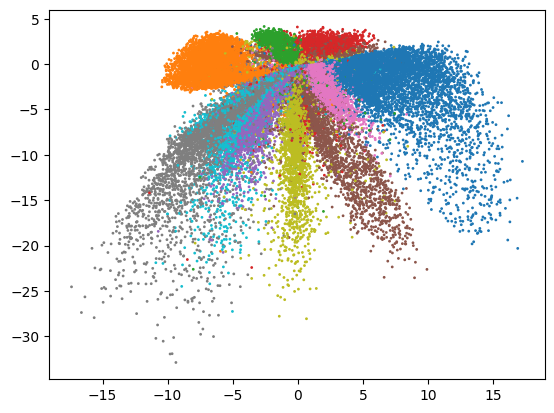

In [9]:
images = []
labels = []
ae.eval()
with torch.no_grad():
    for x, label in dataloader:
        x = x.view(x.size(0), -1).to(device)
        z = ae.encoder(x)
        images.append(z.cpu())
        labels.append(label)
images = torch.cat(images, dim=0)
labels = torch.cat(labels, dim=0)
plt.scatter(images[:, 0], images[:, 1], c=labels, s=1, cmap='tab10');

数字ごとに特徴が表れているのが分かる

#### 学習しなかった場合

学習をしていないencoderで次元削減をするとどうなるのか。

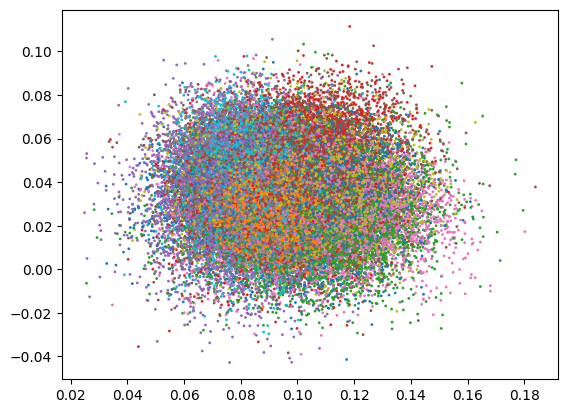

In [10]:
ae = AutoEncoder(z_dim).to(device)

images = []
labels = []
ae.eval()
with torch.no_grad():
    for x, label in dataloader:
        x = x.view(x.size(0), -1).to(device)
        z = ae.encoder(x)
        images.append(z.cpu())
        labels.append(label)
images = torch.cat(images, dim=0)
labels = torch.cat(labels, dim=0)
plt.scatter(images[:, 0], images[:, 1], c=labels, s=1, cmap='tab10');

このように、ごちゃごちゃになる。

ただよく見ると、ほんの少し色に偏りがあると思う。全てのデータに対して同じ処理で2次元に圧縮しているため、元の784次元のベクトルが似ていれば、2次元のベクトルも似たものになる。  
ここで、元の画像と、その白黒を反転させた画像を圧縮して、同じように描画してみよう。

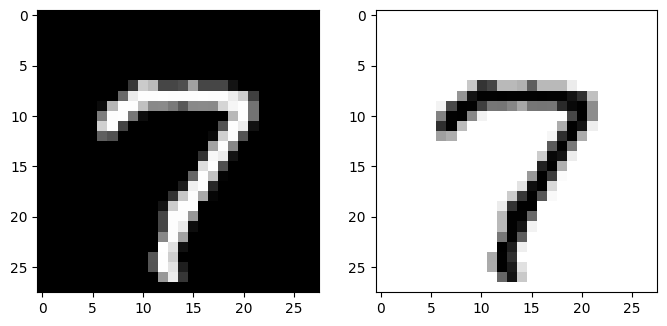

In [11]:
x = next(iter(dataloader))[0][0, 0]
reverse_x = 1 - x
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(x, cmap='gray')
axes[1].imshow(reverse_x, cmap='gray');

左が元の画像、右が反転させた画像

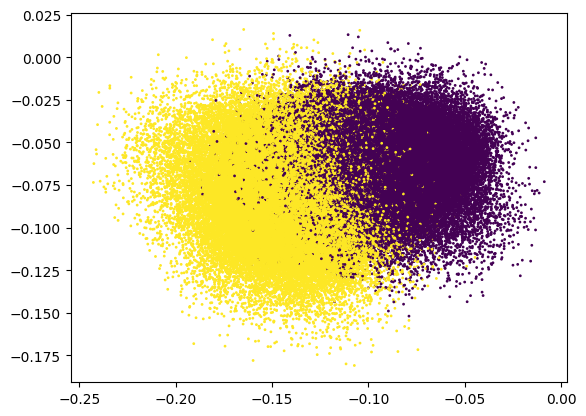

In [12]:
ae = AutoEncoder(z_dim).to(device)

images = []
labels = []
ae.eval()
with torch.no_grad():
    for x, _ in dataloader:
        x = x.view(x.size(0), -1).to(device)
        z = ae.encoder(x)
        images.append(z.cpu())
        labels.append(torch.zeros(len(z)))

        reverse_x = 1 - x
        z = ae.encoder(reverse_x)
        images.append(z.cpu())
        labels.append(torch.ones(len(z)))

images = torch.cat(images, dim=0)
labels = torch.cat(labels, dim=0)
plt.scatter(images[:, 0], images[:, 1], c=labels, s=1);

未学習でも違いが顕著に表れた。

元の画像は黒主体の画像で、反転すると白主体の画像になる。この2種類のベクトル（画像）はベクトル空間$\mathbb{R}^{784}$上で距離が離れているため、適当な関数（未学習のencoder）で2次元空間$\mathbb{R}^2$上に写像しても距離が離れる。  
一方で、その2種類の中での**数字の違いによる$\mathbb{R}^{784}$上の距離**は非常に小さいものとなるため、適当な関数で2次元空間$\mathbb{R}^2$に写像しても違いが表れない。  
違いが表れるようにするには、$\mathbb{R}^{784}$の中で**対象の画像が存在する領域に着目**する必要がある。オートエンコーダを学習させることで、この領域と$\mathbb{R}^2$の対応を正確に捉えられるようになる。

## 異常検知

入力と似た出力が行えるのは、入力が学習に使用したデータと同じ特徴を持っているときだけ。これを使って異常検知を行う。  
具体的な流れは以下

1. 正常なデータで学習させる
2. モデルに何らかのデータを入力する
3. モデルの出力と入力の誤差を計算する
4. 誤差が閾値を超えていたら異常と判定する

<br>

試しに、数字の0だけで学習させてみよう

In [13]:
def train(model, n_epochs, dataloader, critetion, optimizer):
    model.train()
    for epoch in range(n_epochs):
        for x, labels in dataloader:
            if 0 not in labels:
                continue
            x = x[labels == 0] # 0だけ使用
            optimizer.zero_grad()
            x = x.view(x.size(0), -1).to(device)
            y = model(x)
            loss = critetion(y, x)
            loss.backward()
            optimizer.step()
        print(f'{epoch+1:>3}epoch, loss:{loss.item()}')

In [14]:
z_dim = 10
ae = AutoEncoder(z_dim).to(device)
n_epochs = 5
critetion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=1e-3)
train(ae, n_epochs, dataloader, critetion, optimizer)

  1epoch, loss:0.023402540013194084
  2epoch, loss:0.026596447452902794
  3epoch, loss:0.020057277753949165
  4epoch, loss:0.011401002295315266
  5epoch, loss:0.016373436897993088


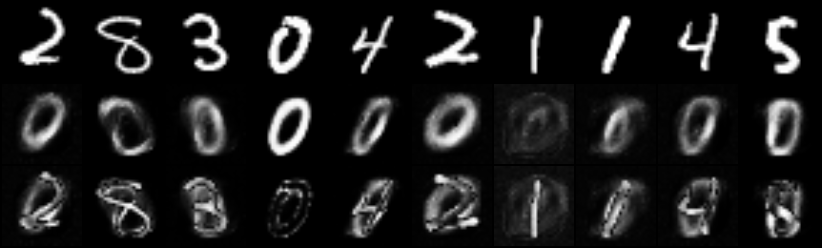

In [15]:
n_images = 10
width = 800

ae.eval()
with torch.no_grad():
    for x, labels in dataloader:
        if 0 not in labels[:n_images]:
            continue
        x = x[:n_images]
        x = x.view(x.size(0), -1).to(device)
        y = ae(x)
        break

x = x.view(n_images, 1, 28, 28).cpu()
y = y.view(n_images, 1, 28, 28).cpu()
diff = (x - y).abs()
diff = (diff - diff.min()) / (diff.max() - diff.min())
f = width // n_images
x = transforms.Resize((f))(x)
y = transforms.Resize((f))(y)
diff = transforms.Resize((f))(diff)
grid = torchvision.utils.make_grid(torch.cat([x, y, diff], dim=0), nrow=n_images)
img = transforms.functional.to_pil_image(grid)
display(img)

- 1段目：入力
- 2段目：出力
- 3段目：入力と出力の差

0以外の数値では上手く復元できていないのが分かる。というかどれも0っぽくなってしまっているね。

差の和を見てみる

In [16]:
print('label: diff')
for diff, label in zip(diff, labels):
    print(f'{label.item():>5}: {diff.sum().item():.3f} ')

label: diff
    2: 783.222 
    8: 717.237 
    3: 790.872 
    0: 236.923 
    4: 614.463 
    2: 993.476 
    1: 828.584 
    1: 734.315 
    4: 715.876 
    5: 689.229 


0が他と比べて小さいのが分かる